In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

import sympy as sym
from sympy.functions.special.delta_functions import DiracDelta
# Heaviside numerics workaround
sympy_modules = [{'Heaviside': lambda x: np.heaviside(x,0.5)}, 'numpy']
from functools import reduce

import numpy as np
import numpy.linalg as la

# import dill # pickle but better
import pickle

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

# Traveling Pulse

In [100]:
file_name = 'synaptic_depression_symbolics.pickle'

# display_mode = 'display'
display_mode = 'latex'
def my_display(expr):
    if display_mode == 'latex':
        print(sym.latex(expr))
    else:
        display(expr)
    return None

# a dictionary of variable definitions
if 'sub_dict' not in globals().keys():
    sub_dict = {}

def recursive_reduce(expression):
    reduced_expression = expression
    while any(v in reduced_expression.free_symbols for v in sub_dict.keys()):
        reduced_expression = reduced_expression.subs(sub_dict)
    return reduced_expression

if 'expr_dict' not in globals().keys():
    expr_dict = {}

In [4]:
ξ, y = sym.symbols('\\xi y', real=True)
α, β, c, Δ, μ = sym.symbols('\\alpha, \\beta, c, \\Delta \\mu', real=True, positive=True)
Q_right = 1
Q_mid = 1/(1+α*β)*(1 + α*β*sym.exp((1+α*β)/(c*α)*ξ))
Q_left = 1 + α*β/(1+α*β)*(sym.exp(-β*Δ/c) - sym.exp(Δ/(α*c)))*sym.exp(ξ/(α*c))
Q = sym.Piecewise((Q_left, ξ<-Δ), (Q_mid, ξ<0), (Q_right, True))
my_display(sym.Eq(sym.Function('Q')(ξ), Q))
expr_dict['Q_left'] = Q_left
expr_dict['Q_mid'] = Q_mid
expr_dict['Q_right'] = Q_right
expr_dict['Q'] = Q

Eq(Q(\xi), Piecewise((\alpha*\beta*(-exp(\Delta/(\alpha*c)) + exp(-\Delta*\beta/c))*exp(\xi/(\alpha*c))/(\alpha*\beta + 1) + 1, \Delta < -\xi), ((\alpha*\beta*exp(\xi*(\alpha*\beta + 1)/(\alpha*c)) + 1)/(\alpha*\beta + 1), \xi < 0), (1, True)))

In [5]:
B1, B2, B3, B4, B5, B6, B7, B8, B9, B10, B11, B12, B13 = sym.symbols([f'B_{i}' for i in range(1, 14)])
r1, r2 = sym.symbols('r_1 r_2')

assumptions = []
sub_dict[r1] = (1+α*β)/(c*α)
sub_dict[B1] = 1/(1+α*β)
sub_dict[B2] = α*β/(1+α*β)

B3_integral_result = sym.integrate(sym.Rational(1,2)*sym.exp(-y)*(B1 + B2*sym.exp(r1*y)), (y, -Δ, 0) )
sub_dict[B3] = B3_integral_result.args[0][0]
assumptions += [B3_integral_result.args[0][1]]

B4_integral_result = sym.integrate(sym.Rational(1,2)*sym.exp(y)*(B1 + B2*sym.exp(r1*y)), (y, -Δ, 0) )
sub_dict[B4] = B4_integral_result.args[0][0]
assumptions += [B4_integral_result.args[0][1]]

sub_dict[B5] = (B2/(1+r1))
sub_dict[B6] = (-B1*sym.exp(-Δ) - B2/(1+r1)*sym.exp(-(1+r1)*Δ))
sub_dict[B7] = (-B2/(r1-1))
sub_dict[B8] = (-B1 + B2/(r1-1))

sub_dict[B9] = (B6/2/(1+c*μ))
sub_dict[B10] = (B8/2/(1-c*μ))
sub_dict[B11] = ((B5+B7)/2/(1-r1*c*μ))
sub_dict[B12] = (B3/(1-c*μ))
sub_dict[B13] = (B4/(1+c*μ))


for key, val in sub_dict.items():
    sub_dict[key] = val.simplify()

print('Assuming')
for assumption in assumptions:
    my_display(assumption.subs(sub_dict))
    
print('with')
for key, val in sub_dict.items():
    my_display(sym.Eq(key, val))

AL, AM = sym.symbols('A_L A_M')
U_left = B12*sym.exp(ξ) + AL*sym.exp(ξ/(c*μ))
U_right = B13*sym.exp(-ξ)
U_mid = B1 + B9*sym.exp(-ξ) + B10*sym.exp(ξ) + B11*sym.exp(r1*ξ) + AM*sym.exp(ξ/(c*μ))
U = sym.Piecewise((U_left, ξ<-Δ), 
                  (U_mid, ξ<0), 
                  (U_right, True))

expr_dict['U'] = U
expr_dict['U_left'] = U_left
expr_dict['U_mid'] = U_mid
expr_dict['U_right'] = U_right

AM_subs = sym.solve( (U_right - U_mid).subs(ξ,0), AM)[0]
sub_dict[AM] = AM_subs.subs(sub_dict)
my_display(sym.Eq(AM, AM_subs))

AL_subs = sym.solve( (U_left - U_mid).subs(ξ,-Δ), AL)[0]
sub_dict[AL] = AL_subs.subs(sub_dict)
my_display(sym.Eq(AL, AL_subs))

my_display(sym.Eq(sym.Function('U')(ξ), U))

Assuming


Ne((\alpha*\beta + 1)/(\alpha*c), 1)

True

with


Eq(r_1, (\alpha*\beta + 1)/(\alpha*c))

Eq(B_1, 1/(\alpha*\beta + 1))

Eq(B_2, \alpha*\beta/(\alpha*\beta + 1))

Eq(B_3, (-B_2*exp(\Delta) + (B_1*r_1*exp(\Delta) - B_1*r_1 - B_1*exp(\Delta) + B_1 + B_2)*exp(\Delta*r_1))*exp(-\Delta*r_1)/(2*(r_1 - 1)))

Eq(B_4, (-B_1*(r_1 + 1)*exp(\Delta*r_1) - B_2 + (B_1*r_1 + B_1 + B_2)*exp(\Delta*(r_1 + 1)))*exp(-\Delta*(r_1 + 1))/(2*(r_1 + 1)))

Eq(B_5, B_2/(r_1 + 1))

Eq(B_6, -(B_1*(r_1 + 1)*exp(\Delta*(r_1 + 1)) + B_2*exp(\Delta))*exp(-\Delta*(r_1 + 2))/(r_1 + 1))

Eq(B_7, -B_2/(r_1 - 1))

Eq(B_8, (-B_1*(r_1 - 1) + B_2)/(r_1 - 1))

Eq(B_9, B_6/(2*(\mu*c + 1)))

Eq(B_10, -B_8/(2*\mu*c - 2))

Eq(B_11, -(B_5 + B_7)/(2*\mu*c*r_1 - 2))

Eq(B_12, -B_3/(\mu*c - 1))

Eq(B_13, B_4/(\mu*c + 1))

Eq(A_M, -B_1 - B_10 - B_11 + B_13 - B_9)

Eq(A_L, A_M + B_1*exp(\Delta/(\mu*c)) + B_10*exp(-\Delta + \Delta/(\mu*c)) + B_11*exp(-\Delta*r_1 + \Delta/(\mu*c)) - B_12*exp(-\Delta + \Delta/(\mu*c)) + B_9*exp(\Delta + \Delta/(\mu*c)))

Eq(U(\xi), Piecewise((A_L*exp(\xi/(\mu*c)) + B_12*exp(\xi), \Delta < -\xi), (A_M*exp(\xi/(\mu*c)) + B_1 + B_10*exp(\xi) + B_11*exp(\xi*r_1) + B_9*exp(-\xi), \xi < 0), (B_13*exp(-\xi), True)))

In [6]:
θ = sym.symbols('\\theta', positive=True)
eq1 = U_mid.subs(ξ, 0) - θ
my_display(sym.Eq(0, eq1))
eq2 = U_mid.subs(ξ, -Δ) - θ
my_display(sym.Eq(0, eq2))
expr_dict['speed_width_conditions'] = (eq1, eq2)

Eq(0, A_M + B_1 + B_10 + B_11 + B_9 - \theta)

Eq(0, A_M*exp(-\Delta/(\mu*c)) + B_1 + B_10*exp(-\Delta) + B_11*exp(-\Delta*r_1) + B_9*exp(\Delta) - \theta)

In [7]:
display(sym.Eq(0, recursive_reduce(eq1).simplify()))
display(sym.Eq(0, recursive_reduce(eq2).simplify()))

Eq(0, (-\alpha**2*\beta*c - 2*\theta*(\alpha*\beta + 1)*(\mu*c + 1)*(\alpha*\beta + \alpha*c + 1)*exp(\Delta*(\alpha*\beta + \alpha*c + 1)/(\alpha*c)) - (\alpha*\beta + \alpha*c + 1)*exp(\Delta*(\alpha*\beta + 1)/(\alpha*c)) + (\alpha*\beta + \alpha*c*(\alpha*\beta + 1) + 1)*exp(\Delta*(\alpha*\beta + \alpha*c + 1)/(\alpha*c)))*exp(-\Delta*(\alpha*\beta + \alpha*c + 1)/(\alpha*c))/(2*(\alpha*\beta + 1)*(\mu*c + 1)*(\alpha*\beta + \alpha*c + 1)))

Eq(0, -\theta - (1/(\alpha*\beta + 1) + (\alpha*\beta/((1 + (\alpha*\beta + 1)/(\alpha*c))*(\alpha*\beta + 1)) + \alpha*\beta/((1 - (\alpha*\beta + 1)/(\alpha*c))*(\alpha*\beta + 1)))/(2 - 2*\mu*(\alpha*\beta + 1)/\alpha) - (\alpha*\beta*exp(\Delta)/(\alpha*\beta + 1) + (1 + (\alpha*\beta + 1)/(\alpha*c))*exp(\Delta*(1 + (\alpha*\beta + 1)/(\alpha*c)))/(\alpha*\beta + 1))*exp(-\Delta*(2 + (\alpha*\beta + 1)/(\alpha*c)))/(2*(1 + (\alpha*\beta + 1)/(\alpha*c))*(\mu*c + 1)) + (\alpha*\beta/(\alpha*\beta + 1) + (1 + (\alpha*\beta + 1)/(\alpha*c))*exp(\Delta*(\alpha*\beta + 1)/(\alpha*c))/(\alpha*\beta + 1) - (\alpha*\beta/(\alpha*\beta + 1) + 1/(\alpha*\beta + 1) + 1/(\alpha*c))*exp(\Delta*(1 + (\alpha*\beta + 1)/(\alpha*c))))*exp(-\Delta*(1 + (\alpha*\beta + 1)/(\alpha*c)))/(2*(1 + (\alpha*\beta + 1)/(\alpha*c))*(\mu*c + 1)) + (\alpha*\beta/(\alpha*\beta + 1) + (1 - (\alpha*\beta + 1)/(\alpha*c))/(\alpha*\beta + 1))/((1 - (\alpha*\beta + 1)/(\alpha*c))*(2*\mu*c - 2)))*exp(-\Delta/(\mu*c))

## Numerics

# Adjoint Nullspace

We seek $v_1, v_2 \in L^2(\mathbb{R})$ such that
$$
\begin{align*}
    -c \mu v_1' &= v_1 - f'(U)Q \bigg[ \int_{\mathbb{R}} w(y,\xi) v_1(y) \ dy - \alpha \beta v_2\bigg] \\
    -c \alpha v_2' &= v_2 - f(U)\bigg[ \int_{\mathbb{R}} w(y, \xi) v_1(y) \ dy - \alpha \beta v_2 \bigg]
\end{align*}
$$
Rearranging, we have
$$
\begin{align*}
    v_1' + \frac{1}{c\mu} v_1 &= \frac{1}{c\mu}f'(U)Q \bigg[ \int_{\mathbb{R}} w(y,\xi) v_1(y) \ dy - \alpha \beta v_2\bigg] \\
    v_2' + \frac{1}{c\alpha}v_2 &= \frac{1}{c\alpha}f(U)\bigg[ \int_{\mathbb{R}} w(y, \xi) v_1(y) \ dy - \alpha \beta v_2 \bigg]
\end{align*}
$$
Choosing $f(\cdot) = H(\cdot - \theta)$ and $w(x,y) = \tfrac{1}{2} e^{-|x - y|}$ we have
$$
\begin{align*}
    v_1' + \frac{1}{c\mu} v_1 &= 
        \frac{1}{c\mu}\bigg( \frac{\delta(\xi)}{U'(0)} + \frac{\delta(\xi + \Delta)}{U'(-\Delta)} \bigg)Q \bigg[ \int_{\mathbb{R}} \tfrac{1}{2} e^{-|y - \xi|} v_1(y) \ dy - \alpha \beta v_2\bigg] \\
    \big[ e^{\frac{1}{c\mu} \xi} v_1 \big]' &=  
         \frac{1}{c\mu}\bigg( \frac{\delta(\xi)}{U'(0)} + \frac{\delta(\xi + \Delta)}{U'(-\Delta)} \bigg)Q e^{\frac{1}{c\mu} \xi} \bigg[ \int_{\mathbb{R}} \tfrac{1}{2} e^{-|y - \xi|} v_1(y) \ dy - \alpha \beta v_2\bigg] \\
    e^{\frac{1}{c\mu} \xi} v_1 &= 
        A_{-\infty} + \frac{1}{c\mu}\frac{Q(0)}{U'(0)} \bigg[ \int_{\mathbb{R}} \tfrac{1}{2}e^{-|y|} v_1(y) \ dy + \alpha \beta v_2(0) \bigg] H(\xi) + \frac{1}{c\mu} e^{-\frac{\Delta}{c\mu}} \frac{Q(-\Delta)}{U'(-\Delta)} \bigg[ \int_{\mathbb{R}} \tfrac{1}{2}e^{-|y + \Delta|} v_1(y) \ dy + \alpha \beta v_2(-\Delta) \bigg] H(\xi + \Delta) \\
    v_1 &= 
        A_{-\infty}e^{-\frac{1}{c\mu} \xi}  + \underbrace{\frac{1}{c\mu}\frac{Q(0)}{U'(0)} \bigg[ \int_{\mathbb{R}} \tfrac{1}{2}e^{-|y|} v_1(y) \ dy + \alpha \beta v_2(0) \bigg]}_{A_{0}} e^{-\frac{1}{c\mu} \xi} H(\xi) + \underbrace{\frac{1}{c\mu} e^{-\frac{\Delta}{c\mu}} \frac{Q(-\Delta)}{U'(-\Delta)} \bigg[ \int_{\mathbb{R}} \tfrac{1}{2}e^{-|y + \Delta|} v_1(y) \ dy + \alpha \beta v_2(-\Delta) \bigg]}_{A_{-\Delta}} e^{-\frac{1}{c\mu} \xi} H(\xi + \Delta) \\
    v_1(\xi) &= A_{-\infty} e^{-\frac{1}{c\mu} \xi} + A_{-\Delta} e^{-\frac{1}{c\mu} \xi} H(\xi + \Delta) + A_{0} e^{-\frac{1}{c\mu} \xi}H(\xi)
\end{align*}
$$
For $v_1$ to be bounded, we need $0 = \lim\limits_{\xi \to -\infty} v_1(\xi) \implies A_{-\infty} = 0$. This gives two consistency conditions
$$
\begin{align*}
    A_{-\Delta} &= \underbrace{\frac{1}{c\mu} e^{-\frac{\Delta}{c\mu}} \frac{Q(-\Delta)}{U'(-\Delta)}}_{D_{-\Delta}} \bigg[ \int \tfrac{1}{2}e^{-|y + \Delta|} \bigg( A_{-\Delta} e^{-\frac{1}{c\mu} y} H(y + \Delta) + A_{0} e^{-\frac{1}{c\mu} y}H(y) \bigg) \ dy + \alpha \beta v_2(-\Delta) \bigg] \\
    A_{0} &= \underbrace{\frac{1}{c\mu}\frac{Q(0)}{U'(0)}}_{D_0} \bigg[ \int \tfrac{1}{2}e^{-|y|} \bigg( A_{-\Delta} e^{-\frac{1}{c\mu} y} H(y + \Delta) + A_{0} e^{-\frac{1}{c\mu} y}H(y) \bigg) \ dy + \alpha \beta v_2(0) \bigg]
\end{align*}
$$

In [101]:
Am, A0, Dm, D0 = sym.symbols('A_{-\\Delta} A_0 D_{-\\Delta} D_0', real=True)
v1 = sym.Function('v_1')
v2 = sym.Function('v_2')

sub_dict[D0] = 1/c/μ * Q_mid.subs(ξ,0)/U_mid.diff(ξ).subs(ξ, 0)
sub_dict[Dm] = 1/c/μ *sym.exp(-Δ/c/μ) * Q_mid.subs(ξ,-Δ)/U_mid.diff(ξ).subs(ξ, -Δ)

expr_dict['v1'] = sym.exp(-1/c/μ *ξ) * (Am*sym.Heaviside(ξ+Δ) + A0*sym.Heaviside(ξ))
argm = sym.exp(-sym.Abs(y+Δ))/2 * expr_dict['v1'].subs(ξ, y)
arg0 = sym.exp(-sym.Abs(y))/2 * expr_dict['v1'].subs(ξ, y)

expr_m = Dm * ( sym.integrate( argm, (y, -sym.oo, sym.oo)) + α*β*v2(-Δ) ) - Am
integral_expression = sym.integrate( arg0, (y, -sym.oo, sym.oo))
#print('assume')
#display(integral_expression.args[0].args[1])
expr_0 = D0 * ( integral_expression.args[0].args[0] + α*β*v2(0) ) - A0

expr_m = expr_m.expand().collect(Am).collect(A0)
expr_0 = expr_0.expand().collect(Am).collect(A0)

my_display(sym.Eq(0, expr_m))
my_display(sym.Eq(0, expr_0))

0 = \frac{A_{0} D_{-\Delta} \mu c e^{\frac{\Delta}{\mu c}}}{2 \mu c e^{\Delta} e^{\frac{\Delta}{\mu c}} + 2 e^{\Delta} e^{\frac{\Delta}{\mu c}}} + A_{-\Delta} \left(\frac{D_{-\Delta} \mu c e^{\frac{\Delta}{\mu c}}}{2 \mu c + 2} - 1\right) + D_{-\Delta} \alpha \beta \operatorname{v_{2}}{\left(- \Delta \right)}
0 = A_{0} \left(\frac{D_{0} \mu c}{2 \mu c + 2} - 1\right) + A_{-\Delta} \left(- \frac{D_{0} \mu c e^{\frac{\Delta}{\mu c}}}{2 \mu c e^{\Delta} - 2 e^{\Delta}} + \frac{D_{0} \mu c}{2 \mu c + 2} + \frac{D_{0} \mu c}{2 \mu c - 2}\right) + D_{0} \alpha \beta \operatorname{v_{2}}{\left(0 \right)}


Also,
$$\begin{align*}
    v_2' + \frac{1}{c\alpha}v_2 &= \frac{1}{c\alpha}f(U)\bigg[ \int_{\mathbb{R}} w(y, \xi) v_1(y) \ dy - \alpha \beta v_2 \bigg]
\end{align*}$$
and we have
$$\begin{align*}
    v_2' + \frac{1}{c\alpha}v_2 &= 0, &\text{ on } \xi & \not\in (-\Delta, 0) \\
    c\alpha v_2' + (1+\alpha\beta)v_2 &= \int_{\mathbb{R}} w(y, \xi) v_1(y) \ dy, & \text{ on } \xi & \in (-\Delta, 0)
\end{align*}$$

In [102]:
integral_expression =   Am/2*( sym.integrate( sym.exp(y-ξ)*sym.exp(-1/c/μ*y), (y, -Δ, ξ) ).args[0].args[0] +\
                               sym.integrate( sym.exp(ξ-y)*sym.exp(-1/c/μ*y), (y, ξ, sym.oo) ) ).expand().collect(sym.exp(ξ)).collect(sym.exp(ξ/μ/c)) + \
                        A0/2 * sym.integrate(sym.exp(ξ-y) * sym.exp(-1/c/μ*y), (y, 0, sym.oo))

integral_expression = integral_expression.expand().collect(sym.exp(ξ)).collect(sym.exp(-ξ/μ/c))
terms = [sym.exp(ξ), sym.exp(-ξ), sym.exp(-ξ/μ/c)]
coeffs = [integral_expression.coeff(term) for term in terms]
coeffs = [(coeff/my_A).simplify() for coeff, my_A in zip(coeffs, [A0, Am, Am])]
terms = [term*my_A for term, my_A in zip(terms, [A0, Am, Am])]
coeffs_sub = [sym.symbols(f'E_{i}', real=True) for i in range(len(terms))]
# coeffs_sub_dict = {k:v for k, v in zip(coeffs_sub, coeffs)}
sub_dict = {**sub_dict, **{k:v for k, v in zip(coeffs_sub, coeffs)} }
integral_expression_sub = sum(term*coeff for term, coeff in zip(terms, coeffs_sub))
assert 0 == (integral_expression - sum(term*coeff for term, coeff in zip(terms, coeffs))).simplify()
assert 0 == (integral_expression - recursive_reduce(integral_expression_sub)).simplify()
print('The rhs is then')
my_display(integral_expression_sub)
print('for')
for k, v in zip(coeffs_sub, coeffs):
    my_display(sym.Eq(k, v))

The rhs is then
A_{0} E_{0} e^{\xi} + A_{-\Delta} E_{1} e^{- \xi} + A_{-\Delta} E_{2} e^{- \frac{\xi}{\mu c}}
for
E_{0} = \frac{\mu c}{2 \left(\mu c + 1\right)}
E_{1} = - \frac{\mu c e^{- \Delta + \frac{\Delta}{\mu c}}}{2 \mu c - 2}
E_{2} = \frac{\mu^{2} c^{2}}{\mu^{2} c^{2} - 1}


In [80]:
v2_mid = sym.dsolve( c*α*v2(ξ).diff(ξ) + (1+α*β)*v2(ξ) - integral_expression_sub, func=v2(ξ),
                     hint='nth_linear_constant_coeff_undetermined_coefficients').args[1]
C1 = sym.symbols('C1')

In [103]:
my_display(v2_mid)

\frac{A_{0} E_{0} e^{\xi}}{\alpha \beta + \alpha c + 1} - \frac{A_{-\Delta} E_{1} e^{- \xi}}{- \alpha \beta + \alpha c - 1} + \frac{A_{-\Delta} E_{2} \mu e^{- \frac{\xi}{\mu c}}}{\alpha \beta \mu - \alpha + \mu} + C_{1} e^{\frac{\xi \left(- \beta - \frac{1}{\alpha}\right)}{c}}


In [104]:
expr_v2 = v2_mid.subs(ξ, -Δ).expand().collect(A0).collect(Am).collect(C1)
expr_m = expr_m.subs(v2(-Δ), 0)
expr_0 = expr_0.subs(v2(0), v2_mid.subs(ξ,0)).expand().collect(A0).collect(Am).collect(C1)
conditions = (expr_m, expr_0, expr_v2)
for condition in conditions:
    my_display(sym.Eq(0, condition))
    
expr_dict['adjoint_nullspace_conditions'] = conditions

0 = \frac{A_{0} D_{-\Delta} \mu c e^{\frac{\Delta}{\mu c}}}{2 \mu c e^{\Delta} e^{\frac{\Delta}{\mu c}} + 2 e^{\Delta} e^{\frac{\Delta}{\mu c}}} + A_{-\Delta} \left(\frac{D_{-\Delta} \mu c e^{\frac{\Delta}{\mu c}}}{2 \mu c + 2} - 1\right)
0 = A_{0} \left(\frac{D_{0} E_{0} \alpha \beta}{\alpha \beta + \alpha c + 1} + \frac{D_{0} \mu c}{2 \mu c + 2} - 1\right) + A_{-\Delta} \left(- \frac{D_{0} E_{1} \alpha \beta}{- \alpha \beta + \alpha c - 1} + \frac{D_{0} E_{2} \alpha \beta \mu}{\alpha \beta \mu - \alpha + \mu} - \frac{D_{0} \mu c e^{\frac{\Delta}{\mu c}}}{2 \mu c e^{\Delta} - 2 e^{\Delta}} + \frac{D_{0} \mu c}{2 \mu c + 2} + \frac{D_{0} \mu c}{2 \mu c - 2}\right) + C_{1} D_{0} \alpha \beta
0 = \frac{A_{0} E_{0}}{\alpha \beta e^{\Delta} + \alpha c e^{\Delta} + e^{\Delta}} + A_{-\Delta} \left(- \frac{E_{1} e^{\Delta}}{- \alpha \beta + \alpha c - 1} + \frac{E_{2} \mu e^{\frac{\Delta}{\mu c}}}{\alpha \beta \mu - \alpha + \mu}\right) + C_{1} e^{\frac{\Delta}{\alpha c}} e^{\frac{\Delta \bet

In [83]:
expr_dict['v2'] = sym.Piecewise(
                    (0, ξ< - Δ),
                    (v2_mid, ξ<0),
                    (v2_mid.subs(ξ, 0)*sym.exp(-1/c/μ * ξ), True)
                )

In [84]:
expr_dict['v2']

Piecewise((0, \Delta < -\xi), (A_0*E_0*exp(\xi)/(\alpha*\beta + \alpha*c + 1) - A_{-\Delta}*E_1*exp(-\xi)/(-\alpha*\beta + \alpha*c - 1) + A_{-\Delta}*E_2*\mu*exp(-\xi/(\mu*c))/(\alpha*\beta*\mu - \alpha + \mu) + C1*exp(\xi*(-\beta - 1/\alpha)/c), \xi < 0), ((A_0*E_0/(\alpha*\beta + \alpha*c + 1) - A_{-\Delta}*E_1/(-\alpha*\beta + \alpha*c - 1) + A_{-\Delta}*E_2*\mu/(\alpha*\beta*\mu - \alpha + \mu) + C1)*exp(-\xi/(\mu*c)), True))

## get numerical parameters

In [87]:
import helper_symbolics
params = {
    'theta': 0.2,
    'alpha': 20,
    'beta': .25,
    'mu': 1
}
precision = 100
numeric_subs = helper_symbolics.get_speed_and_width(params, precision=precision)
# c = float([v for k, v in numerical_params.items() if str(k) == 'c'][0])
# pulse_width = float([v for k, v in numerical_params.items() if str(k) == '\\Delta'][0])
for k, v in numeric_subs.items():
    print(f'{k} = {v}')

# U_numeric, Q_numeric, *_ = helper_symbolics.get_traveling_pulse(numerical_params, precision=precision, validate=False)

\theta = 0.20000000000000000000000000000
\alpha = 20.000000000000000000000000000
\beta = 0.25000000000000000000000000000
\mu = 1.0000000000000000000000000000
c = 1.030045435865679633038580345828761970112975895773849122249103539507323877180428183325981484882257842
\Delta = 9.342632848278734582348146110265447239302673294271547765964725591050019234312324056202624227085276521


In [88]:
numerical_conditions = []
for condition in conditions:
    condition = recursive_reduce(condition).evalf(precision, subs=numeric_subs)
    #print(condition.free_symbols)
    display(sym.Eq(0, condition))
    print()
    numerical_conditions.append(condition)

Eq(0, 0.000000007258392580672051770556812345989301245290184103747722438113897057643816583319894234489587078070128743*A_0 - 0.2798943697154407293602974780311702204388083502965224877915423907057883472536506375784921485752654356*A_{-\Delta})

Eq(0, -2.462976496187265526833370694139614643367719554305471265143998206037286137996352281936923549996649295*A_0 - 12.61992063315944218148190310869959708543238926418236172064216529139351872799182348062273565283752325*A_{-\Delta} - 24.27077401589502239418952037992012161717854845527239171162230343769918280642384805277039180397153573*C1)

Eq(0, 0.0000008355458044680727405609421260836843767836801988246192921442383633156143859914378928170301006017330077*A_0 - 595.4810469301366728439836012551744335144087370266484077901298081848274160458585391520596286684399211*A_{-\Delta} + 15.19604454810015047867319336650438168607406900127447396846477878845034695760856572725156004353798691*C1)

In [89]:
my_vars = [A0, Am, C1]
M = sym.Matrix([
    [condition.coeff(v) for v in my_vars] for condition in numerical_conditions
])

In [90]:
M

Matrix([
[0.000000007258392580672051770556812345989301245290184103747722438113897057643816583319894234489587078070128743, -0.2798943697154407293602974780311702204388083502965224877915423907057883472536506375784921485752654356,                                                                                                      0],
[        -2.462976496187265526833370694139614643367719554305471265143998206037286137996352281936923549996649295,  -12.61992063315944218148190310869959708543238926418236172064216529139351872799182348062273565283752325, -24.27077401589502239418952037992012161717854845527239171162230343769918280642384805277039180397153573],
[  0.0000008355458044680727405609421260836843767836801988246192921442383633156143859914378928170301006017330077,  -595.4810469301366728439836012551744335144087370266484077901298081848274160458585391520596286684399211,  15.19604454810015047867319336650438168607406900127447396846477878845034695760856572725156004353798691]])

In [91]:
M.det()

-10.47584729830458902626018744368625481921002539191198422349771367698580149757362144598723543229410221

In [92]:
M_ndarray = np.array(M, dtype=np.float)
print(f'cond = {la.cond(M_ndarray):.5g}')
eigen_vals, eigen_vect_mat = la.eig(M_ndarray)
eigen_val, eigen_vect = sorted(zip(eigen_vals, eigen_vect_mat.T), key=lambda tup: abs(tup[0]))[0]
print(eigen_vals)
print(eigen_vect_mat)
display(sym.Eq(sym.symbols('\\lambda'), eigen_val))
for var, sub in zip(my_vars, eigen_vect):
    numeric_subs[var] = sub

cond = 8.3705e+05
[ 7.15306826e-04 -1.19736707e+02  1.22312116e+02]
[[ 9.95019164e-01 -5.16587132e-04  4.05131775e-04]
 [-2.54287636e-03 -2.20992091e-01 -1.77040091e-01]
 [-9.96513789e-02 -9.75275463e-01  9.84203557e-01]]


Eq(\lambda, 0.000715306825725293)

# Plot nullspace basis

In [93]:
recursive_reduce(expr_dict['v1']).evalf(precision, subs=numeric_subs)

(0.99501916386986177798235075897537171840667724609375*Heaviside(\xi) - 0.00254287636485074630687819308150210417807102203369140625*Heaviside(\xi + 9.342632848278734582348146110265447239302673294271547765964725591050019234312324056202624227085276521))*exp(-0.9708309606358008957675808151979732710609567124303613072534000631302004749911450258222324782819382615*\xi)

In [ ]:
v1_numeric = sym.lambdify(ξ, recursive_reduce(expr_dict['v1']).evalf(precision, subs=numeric_subs), modules=sympy_modules)
v2_numeric = sym.lambdify(ξ, recursive_reduce(expr_dict['v2']).evalf(precision, subs=numeric_subs), modules=sympy_modules)

# Save Expressions

In [85]:
expr_dict['sub_dict'] = sub_dict
with open(file_name, 'wb') as f:
    pickle.dump(expr_dict, f)

# Test Saved Expressions

In [95]:
import helper_symbolics
params = {
    'theta': 0.2,
    'alpha': 20,
    'beta': .25,
    'mu': 1
}
precision = 15
U_numeric, Q_numeric, *_ = helper_symbolics.get_traveling_pulse(params, precision=precision)

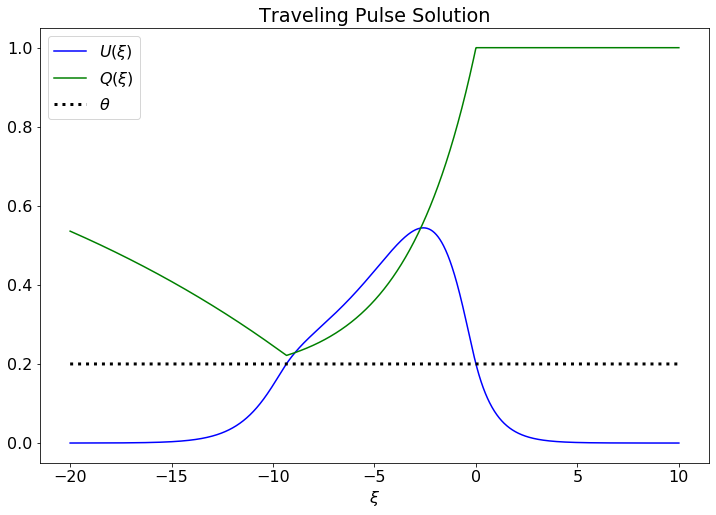

In [96]:
xs = np.linspace(-20,10, 2001)

plt.figure(figsize=(12,8))

plt.plot(xs, U_numeric(xs), 'b-', label='$U(\\xi)$')
plt.plot(xs, Q_numeric(xs), 'g-', label='$Q(\\xi)$')
plt.plot(xs, float(params['theta']) + 0*xs, 'k:', label='$\\theta$', linewidth=3)
plt.legend()
plt.title('Traveling Pulse Solution')
plt.xlabel('$\\xi$')

# plt.savefig('traveling_pulse.eps')

plt.show()

In [97]:
v1_numeric, v2_numeric = helper_symbolics.get_adjoint_nullspace(params, precision=precision)

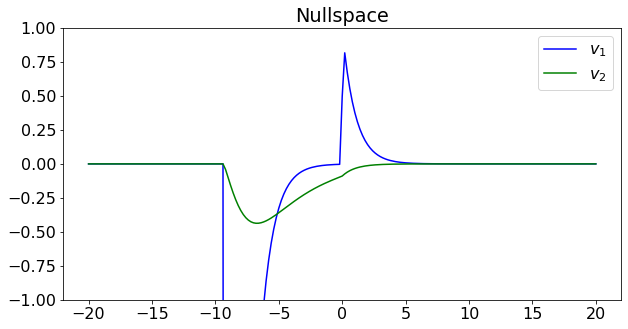

In [98]:
xs = np.linspace(-20, 20, 201)
plt.figure(figsize=(10, 5))
plt.plot(xs, v1_numeric(xs), 'b-', label='$v_1$')
plt.plot(xs, v2_numeric(xs), 'g-', label='$v_2$')
plt.ylim(-1, 1)
plt.legend()
plt.title('Nullspace')
# plt.savefig('adjoint_nullspace_basis.eps')
plt.show()